In [170]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [171]:
df = pd.read_csv("retail_store_inventory.csv")
df["Date"] = pd.to_datetime(df["Date"], errors='coerce') #handle datatype 

store1=df[df["Store ID"]=="S001"]
store2=df[df["Store ID"]=="S002"]
store3=df[df["Store ID"]=="S003"]
store4=df[df["Store ID"]=="S004"]
store5=df[df["Store ID"]=="S005"]

data=store1 # 1. store 

sp1 = data.groupby(['Date','Product ID']).sum()
sp1_filtered = sp1.loc[sp1.index.get_level_values('Product ID') == 'P0001']
sp1_filtered_reset = sp1_filtered.reset_index(level='Product ID', drop=True)
unit = sp1_filtered_reset[['Units Sold']].reset_index()

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22858/4045106535.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sp1 = data.groupby(['Date','Product ID']).sum()


In [172]:
unit = unit.rename(columns={'Date': 'ds', 'Units Sold': 'y'})  # Rename columns for Prophet
unit['ds'] = pd.to_datetime(unit['ds'])

In [173]:
# Train-test split
train_data = unit.iloc[:-30]
test_data = unit.iloc[-30:]

# Step 2: Train Prophet
prophet_model = Prophet()
prophet_model.fit(train_data)

17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing


In [174]:
# Predict on full data
future = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future)

In [175]:
# Extract residuals
train_residuals = train_data['y'] - prophet_forecast['yhat'][:len(train_data)]

In [176]:
# Step 3: Train XGBoost on Residuals
# Create features for XGBoost (e.g., lag features)
train_data['residuals'] = train_residuals
train_data['day_of_week'] = train_data['ds'].dt.dayofweek
train_data['day_of_month'] = train_data['ds'].dt.day
train_data['month'] = train_data['ds'].dt.month

# Lag feature
train_data['lag_1'] = train_data['y'].shift(1)
train_data = train_data.dropna()

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22858/1012702632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['residuals'] = train_residuals
/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22858/1012702632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['day_of_week'] = train_data['ds'].dt.dayofweek
/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22858/1012702632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [177]:
# Features and target for XGBoost
X = train_data[['day_of_week', 'day_of_month', 'month', 'lag_1']]
y = train_data['residuals']

In [253]:
# Train-test split for XGBoost
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost model
# xgb_model = XGBRegressor(n_estimators=10000, learning_rate=0.001, max_depth=500, random_state=42)
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01,max_depth= 50, random_state=42)
xgb_model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [254]:
# Step 4: Predict on Test Data
# Prophet predictions
prophet_test_forecast = prophet_forecast.iloc[-30:]

# XGBoost predictions
test_data['day_of_week'] = test_data['ds'].dt.dayofweek
test_data['day_of_month'] = test_data['ds'].dt.day
test_data['month'] = test_data['ds'].dt.month
test_data['lag_1'] = test_data['y'].shift(1)
test_data = test_data.dropna()

X_test = test_data[['day_of_week', 'day_of_month', 'month', 'lag_1']]
xgb_predictions = xgb_model.predict(X_test)

In [255]:
prophet_test_forecast = prophet_test_forecast.iloc[:len(xgb_predictions)]
final_predictions = 0.7 * prophet_test_forecast['yhat'].values + 0.3 * xgb_predictions

In [256]:
mae = mean_absolute_error(test_data['y'], final_predictions)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 74.52


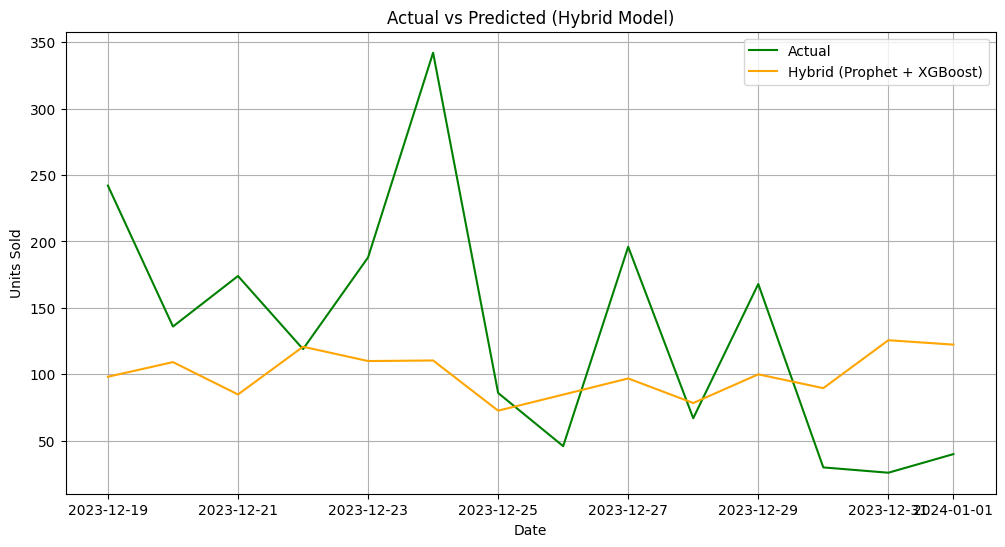

In [257]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='green')
plt.plot(test_data['ds'], final_predictions, label='Hybrid (Prophet + XGBoost)', color='orange')
plt.title('Actual vs Predicted (Hybrid Model)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid()
plt.show()
